In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [5]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

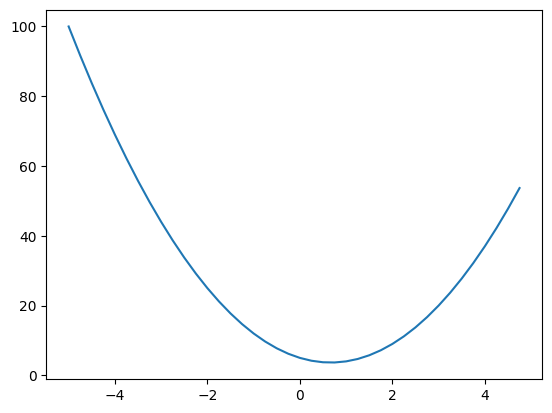

In [6]:
plt.plot(xs, ys)

In [7]:
h = 0.001
x = 3.0
(f(x+h) - f(x))/h

14.00300000000243

In [8]:
# more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [9]:
h = 0.0001

# fix inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope da/dh', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope da/dh -3.000000000010772


In [10]:
# fix inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope db/dh', (d2-d1)/h)

d1 4.0
d2 4.0002
slope db/dh 2.0000000000042206


In [11]:
# fix inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope dc/dh', (d2-d1)/h)

d1 4.0
d2 4.0001
slope dc/dh 0.9999999999976694


In [91]:
class Value:
    def __init__(self, data, _children = (), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None
        self.label = label
        # initial derivative/gradient
        self.grad = 0.0

    # pretty print in python for custom obj
    def __repr__(self):
        return f'Value(data={self.data})'

    # out.grad is parent gradient
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        # addition
        # local derivative is constant 1 for one of the operand, and 0 for the other,
        # so it routes parent nodes gradient
        def _backward():
            # current node gradient = 1 * parent gradient (chain rule)
            self.grad += 1.0 * out.grad
            # other operand node gradient = 1 * parent gradient
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        
        return out

    def __radd__(self, other): # fallback for __add__ reverse operands
        return self + other
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            # local derivative
            self.grad += other.data * out.grad
            # children derivative
            other.grad += self.data * out.grad
            
        out._backward = _backward
        
        return out

    def __rmul__(self, other): # fallback for __mul__ to revers operands
        return self * other
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
            
        out._backward = _backward
        
        return out

    def __truediv__(self, other): # self / other
        return self * (other**-1)

    def __pow__(self, other): # self^other
        assert isinstance(other, (int, float)), 'only support int/float powers for now'
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * self.data**(other - 1) * out.grad
            
        out._backward = _backward
        
        return out

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)
        
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out
        
    def backward(self):
        # backward auto
        # using topological sort.
        # operation graph is a DAG, sort all nodes based on dependency graph
        # we can use toplogical sort for this.
        # isnt this just Depth First Search?
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        

In [92]:
a = Value(3.0)
b = Value(6.0)
3 + a

Value(data=6.0)

In [13]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')

In [14]:
c = Value(10.0, label='c')
e = a * b; e.label = 'e'

In [15]:
a*b + c

Value(data=4.0)

In [16]:
(a.__mul__(b)).__add__(c)

Value(data=4.0)

In [17]:
d = e + c; d.label = 'd'
d

Value(data=4.0)

In [18]:
d._prev, d._op

({Value(data=-6.0), Value(data=10.0)}, '+')

In [21]:
from graphviz import Digraph

In [22]:
def trace(root):
    # builds set of nodes and edges in graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, creat a rect ('record') node for it
        dot.node(name=uid, label='{ %s | data %.4f | grad %.4f}' % (n.label, n.data, n.grad ), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge( str(id(n1)), str(id(n2)) + n2._op)

    return dot

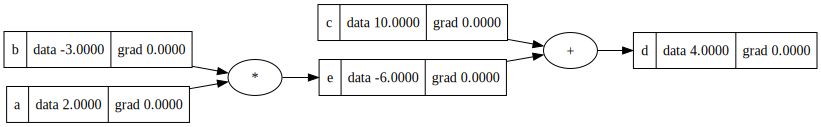

In [23]:
draw_dot(d)

In [24]:
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
L

Value(data=-8.0)

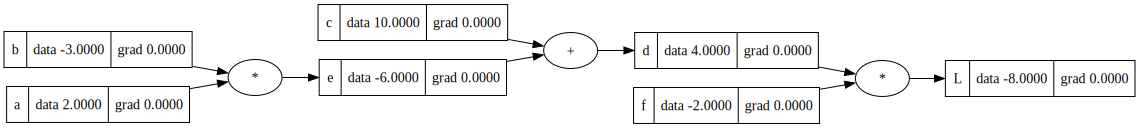

In [25]:
draw_dot(L) # forward pass, final value L

In [26]:
# dummy derivative calculation

def lol():
    h = 0.001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0 + h, label='b')
    c = Value(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d*f; L.label = 'L'
    L2 = L.data

    print( (L2 - L1) / h )

In [27]:
lol()

-3.9999999999995595


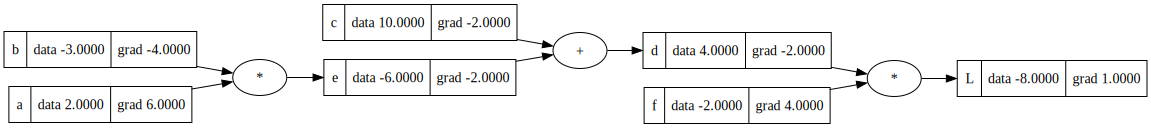

In [28]:
# manual backward pass

# dL/dL = 1
L.grad = 1
# dL/df = (f(x+h)-f(x))/h = ((f+h)*d - d*f)/h = (d*f + h*d - d*f)/h = d
f.grad = 4
# dL/dd = (f(x+h)-f(x))/h = ((d+h)*f - d*f)/h = (d*f + h*f - d*f)/h = f
d.grad = -2
# dd/dc = (f(x+h)-f(x))/h = ((c+h)+e - (c+e))/h = 1
# dL/dc = dL/dd * dd/dc = f * 1 = f
c.grad = -2
# dd/de = (f(x+h)-f(x))/h = (c+(e+h) - (c+e))/h = 1
# dL/de = dL/dd * dd/de = f * 1 = f
e.grad = -2

# de/da = b
# dL/da = dL/de * de/da = -2 * -3
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2
draw_dot(L)

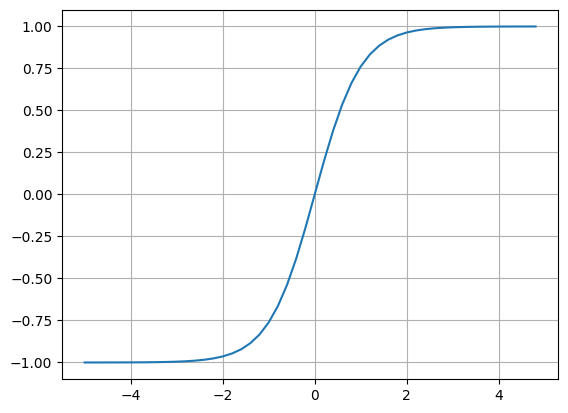

In [29]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid();

In [62]:
# forward pass
# 2d inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.881375, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x2w2 + x1w1; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

o.backward()

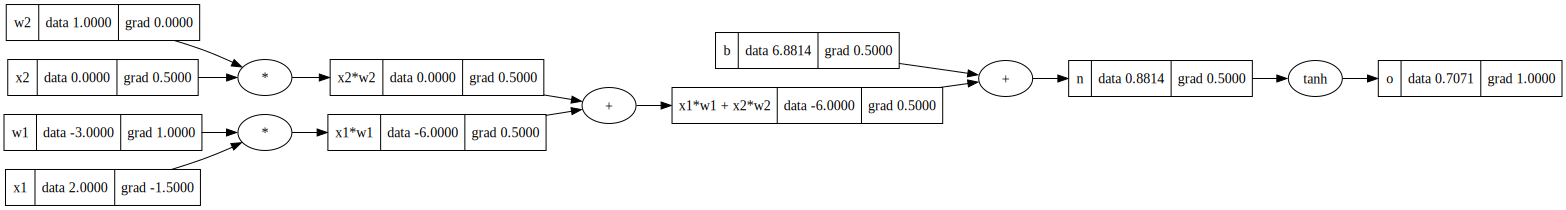

In [64]:
draw_dot(o)

In [65]:
# forward pass
# 2d inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.881375, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x2w2 + x1w1; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ---- use e^x for tanh
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'o'
# ----
o.backward()

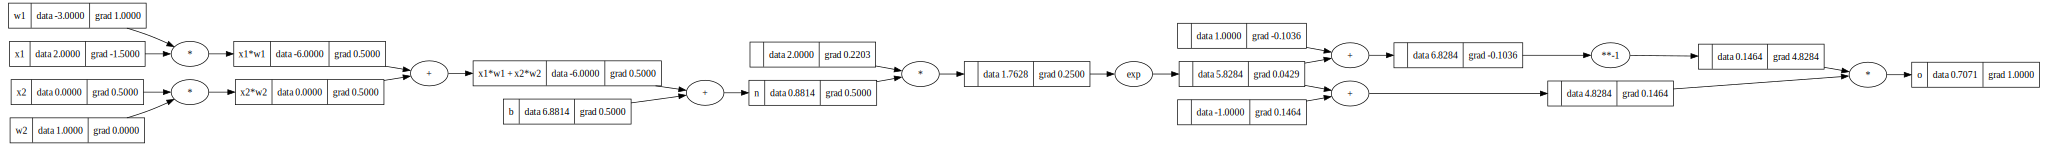

In [66]:
draw_dot(o)

In [75]:
# use pytorch
import torch
import random

In [68]:
x1 = torch.Tensor([2.0]).double();  x1.requires_grad = True
x2 = torch.Tensor([0.0]).double();  x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double();  w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();  w2.requires_grad = True

b = torch.Tensor([6.881373587]).double();  b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('----')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
----
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [122]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

In [127]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

In [124]:
class MLP:
    # nouts is a list, because it defines size of multiple layers
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)

        return out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [222]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)

Value(data=0.46733484927835905)

In [223]:
len(n.parameters())

41

In [224]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [244]:

for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += 0.05 * -p.grad

    print(k, loss.data)

0 0.0010410233224561547
1 0.0010376445087683934
2 0.0010342870668645142
3 0.0010309507977282108
4 0.0010276355047792102
5 0.0010243409938364158
6 0.0010210670730816571
7 0.0010178135530242499
8 0.0010145802464659969
9 0.0010113669684669903
10 0.001008173536311849
11 0.001004999769476744
12 0.0010018454895968027
13 0.0009987105204342691
14 0.0009955946878471111
15 0.0009924978197582393
16 0.000989419746125201
17 0.0009863602989104697
18 0.0009833193120522025
19 0.000980296621435538


In [245]:
ypred

[Value(data=0.9878937269222148),
 Value(data=-0.9880449826995489),
 Value(data=-0.9764354740238661),
 Value(data=0.9883584601333133)]